<a href="https://colab.research.google.com/github/MonicaKim89/Sign_recognition/blob/main/%5B0916%5D(auc05)_fragile_prevgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard
from time import time

In [8]:
from google.colab import files 
src = list(files.upload().values())[0] 
open('deeplearning_check.py','wb').write(src)



Saving deeplearning_check.py to deeplearning_check.py


7903

In [9]:
from google.colab import files 
src = list(files.upload().values())[0] 
open('basic_preprocessing.py','wb').write(src)

Saving basic_preprocessing.py to basic_preprocessing.py


5233

In [10]:
from google.colab import files 
src = list(files.upload().values())[0] 
open('machine_learning.py','wb').write(src)

Saving machine_learning.py to machine_learning.py


5310

In [11]:
!pip install split_folders

In [12]:
from basic_preprocessing import *
from deeplearning_check import *
from machine_learning import *

gpu_check()
set_global_determinism(seed=SEED)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5727720355397607650
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2366639589865586330
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
tf 2.6.0
keras 2.6.0
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라


#### basic model

In [13]:
set_global_determinism(seed=1337)

In [14]:
train_dir = '/content/drive/MyDrive/Sign Detection/Binary_dataset/Fragile_non/train'
test_dir = '/content/drive/MyDrive/Sign Detection/Binary_dataset/Fragile_non/test'
val_dir = '/content/drive/MyDrive/Sign Detection/Binary_dataset/Fragile_non/val'

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(200,200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(200, 200), color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(200, 200), color_mode='rgb')

input_tensor = Input(shape=(200, 200, 3), dtype='float32', name='input')

Found 548 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


#### model creating

In [55]:
def create_model():
    optimizer = optimizers.SGD(lr= 0.01, decay = 1e-6, momentum= 0.9, nesterov=True)
    
    pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    #include_top FC 레이어 포함유무 결정
    #feature extraction 파라미터들은 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에 trainable의 속성을 False
    pre_trained_vgg.trainable = False
    additional_model = tf.keras.Sequential()
    additional_model.add(pre_trained_vgg)
    additional_model.add(Flatten())
    additional_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(2048, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(1024, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(2, activation='softmax'))
    

    additional_model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics=['acc'])

    #adam보다 빠르고 loss잘 떨어짐

    
    return additional_model

In [56]:
tf.__version__

'2.6.0'

In [57]:
keras.__version__

'2.6.0'

In [58]:
# 모델 실행 옵션 
model = create_model()
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              75501568  
_________________________________________________________________
dense_17 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 2050      
Total params: 100,707,138
Trainable params: 85,992,450
Non-trainable params: 14,714,688
________________________________

In [59]:
checkpoint_path = "check_point/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [62]:
#모델의 가중치 저장
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
            monitor='loss', 
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)

#새로운 콜백으로 모델 훈련하기
history = model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=100, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint],
            shuffle=False)

Epoch 1/100
35/35 [==============================] - 7s 192ms/step - loss: 0.0382 - acc: 0.9891 - val_loss: 0.1271 - val_acc: 0.9412

Epoch 00001: loss improved from inf to 0.03824, saving model to check_point/cp.ckpt
Epoch 2/100
35/35 [==============================] - 7s 191ms/step - loss: 0.0238 - acc: 0.9909 - val_loss: 0.3221 - val_acc: 0.9412

Epoch 00002: loss improved from 0.03824 to 0.02383, saving model to check_point/cp.ckpt
Epoch 3/100
35/35 [==============================] - 7s 191ms/step - loss: 0.0443 - acc: 0.9891 - val_loss: 0.2213 - val_acc: 0.9265

Epoch 00003: loss did not improve from 0.02383
Epoch 4/100
35/35 [==============================] - 7s 191ms/step - loss: 0.1887 - acc: 0.9507 - val_loss: 0.2975 - val_acc: 0.9412

Epoch 00004: loss did not improve from 0.02383
Epoch 5/100
35/35 [==============================] - 7s 191ms/step - loss: 0.0854 - acc: 0.9872 - val_loss: 0.2352 - val_acc: 0.9265

Epoch 00005: loss did not improve from 0.02383
Epoch 6/100
35/35

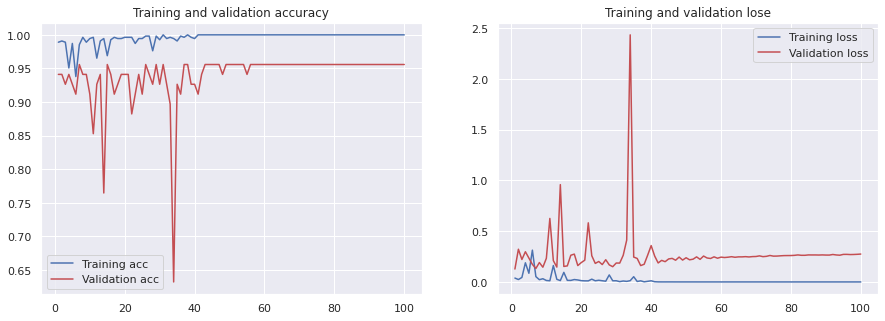

In [63]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

In [64]:
#맥에서는 !ls
#저장된 checkpoint확인하기
!dir {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [65]:
#가장 마지막에 만들어진 체크포인트 확인
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'check_point/cp.ckpt'

In [66]:
# 기본 모델 객체를 만듭니다
model = create_model()

# 모델을 평가합니다
loss, acc = model.evaluate(val_generator, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

5/5 - 1s - loss: 0.7691 - acc: 0.4412
훈련되지 않은 모델의 정확도: 44.12%


In [67]:
# 가중치 로드
model.load_weights(latest)

# # 모델 재평가
loss,acc = model.evaluate(val_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

5/5 [==============================] - 1s 142ms/step - loss: 0.2722 - acc: 0.9559
복원된 모델의 정확도: 95.59%


accuracy가 높게 나올 수 있음, 데이터가 불균형일 경우 더 높게 나올 수 있음  

(아닌걸 아니라고 분류하면되니까) 따라서 좋은 지표는 아님 auc등을 살펴봐야함

#### final model save

In [68]:
model.save('[0916]colab_fragile.h5')

model_json = model.to_json()
with open("[0916]colab_fragile.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("[0916]colab_fragile_weight.h5")
print("Saved model to disk")

Saved model to disk


In [69]:
/pwd

'/content'

In [70]:
label_dict = get_label_dict(train_generator)
label_dict

{0: 'fragile', 1: 'non_fragile'}

In [71]:
def predict (model, real_path):
    img_list = get_img(real_path)
    try:
        for num, i in enumerate (img_list):
            resized_frame = cv2.resize(i, (200,200))
            frame_for_pred = prepare_image_for_prediction( resized_frame )
            pred_vec = model.predict(frame_for_pred)
            pred_class =[]
            confidence = np.round(pred_vec.max(),2)
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
            txt = get_display_string(pred_class, label_dict)
            i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
            # show(i)
            print(txt)
    except TypeError:
        print('error')
        pass
    else:
        pass

In [39]:
real_path = '/content/drive/MyDrive/Sign Detection/ML/test/'

In [ ]:
get_file_list(real_path)

### Real Test (test_set 겹침)

In [321]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [366]:
file_list = get_file_list('/content/drive/MyDrive/Sign Detection/ML/test/')
print(len(file_list))

73


In [368]:
file_list = file_list[1:]

In [ ]:
img_list=[]
for i in file_list:
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    input_img = prepare_image_for_prediction(img)
    img_list.append(input_img)


img_list[0]

In [370]:
predicted_class = []

for i in img_list:
    pred_vec = model.predict(i)
    confidence = np.round(pred_vec.max(),2)
    pc = pred_vec.argmax()
    predicted_class.append(pc)

In [371]:
len(file_list)

72

In [372]:
answer_test = []

for i in file_list:
    if 'fragile' in i:
        answer_test.append('0')
    else :
        answer_test.append('1')

In [373]:
print(len(predicted_class))
print(len(answer_test))

72
72


In [374]:
answer = []
for i in answer_test:
    i = int(i)
    answer.append(i)

In [375]:
prediction = []
for i in predicted_class:
    i = int(i)
    prediction.append(i)

오차 행렬
[[26  5]
 [ 3 38]]
정확도: 0.8889, 정밀도: 0.8837, 재현율: 0.9268,    F1: 0.9048, AUC:0.8828


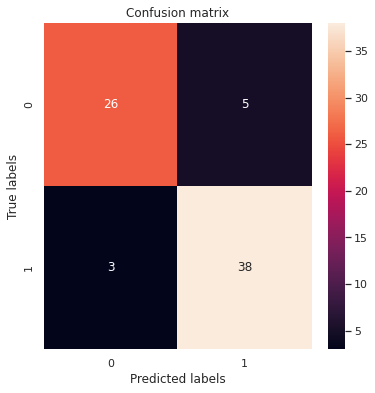

In [380]:
confusion = get_clf_eval(answer, prediction)
# con_test = confusion_matrix(val_generator.classes, predicted_classes)
confusion_plot(confusion, 6)

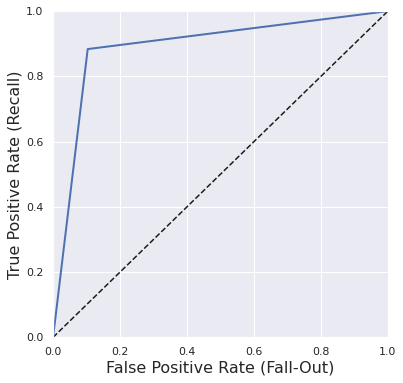

In [382]:
plt.figure(figsize=(6,6))
fpr, tpr, thresh= roc_curve(prediction, answer)
plot_roc_curve(fpr, tpr)

### confusion matrix

#### validation set

[0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0
 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0]
Confusion Matrix
[[14 16]
 [15 23]]
              precision    recall  f1-score   support

     fragile       0.48      0.47      0.47        30
 non_fragile       0.59      0.61      0.60        38

    accuracy                           0.54        68
   macro avg       0.54      0.54      0.54        68
weighted avg       0.54      0.54      0.54        68

오차 행렬
[[14 16]
 [15 23]]
정확도: 0.5441, 정밀도: 0.5897, 재현율: 0.6053,    F1: 0.5974, AUC:0.5360


array([[14, 16],
       [15, 23]])

<Figure size 432x432 with 0 Axes>

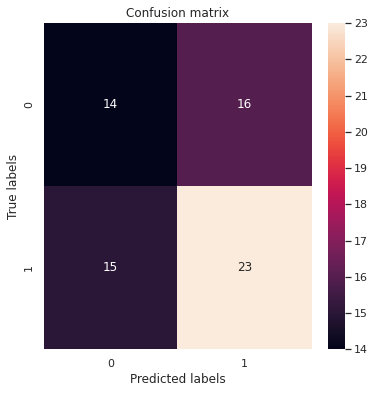

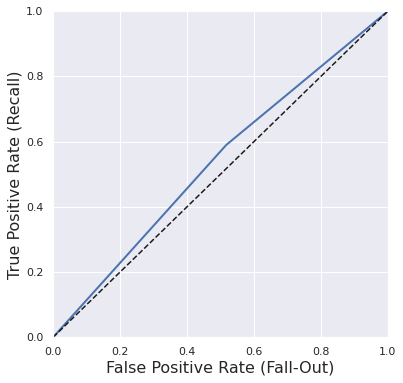

In [391]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)


predictions = model.predict_generator(val_generator, steps=test_steps_per_epoch)

# Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)
# 2.Get ground-truth classes and class-labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, predicted_classes))
print(report)

plt.figure(figsize=(6,6))
con_test = confusion_matrix(val_generator.classes, predicted_classes)
confusion_plot(con_test, 6)

plt.figure(figsize=(6,6))
fpr, tpr, thresh= roc_curve(predicted_classes, val_generator.classes)
plot_roc_curve(fpr, tpr)

get_clf_eval(val_generator.classes,predicted_classes)

#### test_set

[1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0]
Confusion Matrix
[[11 20]
 [18 23]]
              precision    recall  f1-score   support

     fragile       0.38      0.35      0.37        31
 non_fragile       0.53      0.56      0.55        41

    accuracy                           0.47        72
   macro avg       0.46      0.46      0.46        72
weighted avg       0.47      0.47      0.47        72

오차 행렬
[[11 20]
 [18 23]]
정확도: 0.4722, 정밀도: 0.5349, 재현율: 0.5610,    F1: 0.5476, AUC:0.4579


array([[11, 20],
       [18, 23]])

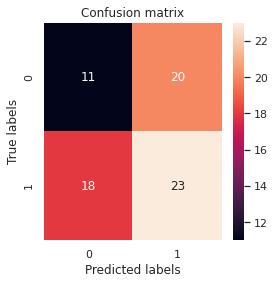

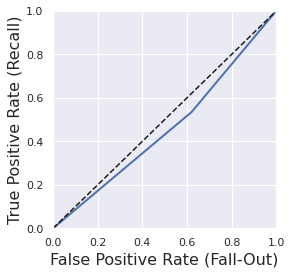

In [390]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)

# Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)
# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))
print(report)    
con = confusion_matrix(test_generator.classes, predicted_classes)
confusion_plot(con, 4)

plt.figure(figsize=(4,4))
fpr, tpr, thr = roc_curve(predicted_classes, test_generator.classes)
plot_roc_curve(fpr, tpr)\



get_clf_eval(test_generator.classes,predicted_classes)